# Statistical forecast
## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
import statsmodels.api as stm
from statsmodels.stats.diagnostic import het_breuschpagan, linear_reset

## Load data
Load the data from previous files.

In [2]:
predicted_percipitation: pd.DataFrame = pd.read_hdf("prediction_data.hdf5", "prediction_data_24h")
predicted_percipitation

,,det_run,E1,E2,E3,E4,E5,E6,E7,E8,E9,...,mean_pred,median_pred,min_pred,max_pred,pred_std,pred_skew,pred_kurt,mode_pred,mode2_pred,mean_det_pred
date,loc_nr,,,,,,,,,,,,,,,,,,,,,
2016-04-01,260,0,0,0,0,0,0,0,0,0,0,...,0.16,0.0,0,3,0.509502,4.129082,19.937964,0.000000,0.0,0.08
2016-04-02,260,1,1,5,2,3,3,1,1,2,1,...,2.66,2.0,0,16,3.360090,2.668093,7.322484,2.000000,2.0,1.83
2016-04-03,260,34,20,8,22,19,26,19,28,12,25,...,25.90,22.0,8,75,14.570378,1.523376,2.709633,19.333333,19.0,29.95
2016-04-04,260,17,44,54,29,29,44,54,9,61,22,...,33.40,29.0,7,88,16.099182,1.028039,1.597512,36.200000,29.0,25.20
2016-04-05,260,30,18,8,24,58,36,41,30,43,25,...,31.30,31.5,8,62,15.708116,0.159005,-1.070315,8.000000,8.0,30.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,240,0,0,0,0,0,0,0,0,0,0,...,0.00,0.0,0,0,0.000000,0.000000,0.000000,0.000000,0.0,0.00
2021-04-27,240,0,0,0,0,2,0,0,1,0,1,...,0.36,0.0,0,3,0.692820,2.062579,4.056756,0.000000,0.0,0.18
2021-04-28,240,41,27,10,38,29,5,31,14,32,20,...,22.82,21.0,3,59,14.342302,0.655763,-0.160606,14.000000,14.0,31.91


### Calculate daily rainfall
Here we calculate the daily rainfall.

In [3]:
true_weather = pd.read_hdf("weather_data.hdf5", "measured_data")
rainfall: pd.DataFrame = true_weather["RH-fix"]
daily_rainfall = rainfall.groupby([pd.Grouper(freq="D", level=0), rainfall.index.get_level_values(1)]).sum()
daily_rainfall.index.rename(["date", "loc_nr"], inplace=True)
daily_rainfall = daily_rainfall * 10
daily_rainfall

date        loc_nr
1951-01-01  240         0.0
            260        23.0
            310         0.0
1951-01-02  240         0.0
            260        25.0
                      ...  
2022-06-05  260       259.0
            310       209.0
2022-06-06  240        44.0
            260       114.0
            310       109.0
Name: RH-fix, Length: 78267, dtype: float64

### Calculate if has rained
Here we calculate if it has rained.

In [4]:
is_raining: pd.Series = true_weather["R"]
daily_is_raining = is_raining.groupby([pd.Grouper(freq="D", level=0), rainfall.index.get_level_values(1)]).max()
daily_is_raining

date        STN
1951-01-01  240    1.0
            260    1.0
            310    1.0
1951-01-02  240    1.0
            260    1.0
                  ... 
2022-06-05  260    1.0
            310    1.0
2022-06-06  240    1.0
            260    1.0
            310    1.0
Name: R, Length: 78267, dtype: float64

Finally we join this data with the predicted data.

In [5]:
combined_data = predicted_percipitation.join([daily_rainfall, daily_is_raining])
# combined_data = combined_data.loc[combined_data.index.get_level_values(1) == 260] # Only run on one station
combined_data

,,det_run,E1,E2,E3,E4,E5,E6,E7,E8,E9,...,min_pred,max_pred,pred_std,pred_skew,pred_kurt,mode_pred,mode2_pred,mean_det_pred,RH-fix,R
date,loc_nr,,,,,,,,,,,,,,,,,,,,,
2016-04-01,260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.509502,4.129082,19.937964,0.000000,0.0,0.08,0.0,0.0
2016-04-02,260,1.0,1.0,5.0,2.0,3.0,3.0,1.0,1.0,2.0,1.0,...,0.0,16.0,3.360090,2.668093,7.322484,2.000000,2.0,1.83,0.0,1.0
2016-04-03,260,34.0,20.0,8.0,22.0,19.0,26.0,19.0,28.0,12.0,25.0,...,8.0,75.0,14.570378,1.523376,2.709633,19.333333,19.0,29.95,97.0,1.0
2016-04-04,260,17.0,44.0,54.0,29.0,29.0,44.0,54.0,9.0,61.0,22.0,...,7.0,88.0,16.099182,1.028039,1.597512,36.200000,29.0,25.20,63.0,1.0
2016-04-05,260,30.0,18.0,8.0,24.0,58.0,36.0,41.0,30.0,43.0,25.0,...,8.0,62.0,15.708116,0.159005,-1.070315,8.000000,8.0,30.65,14.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.0
2021-04-27,240,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,...,0.0,3.0,0.692820,2.062579,4.056756,0.000000,0.0,0.18,0.0,0.0
2021-04-28,240,41.0,27.0,10.0,38.0,29.0,5.0,31.0,14.0,32.0,20.0,...,3.0,59.0,14.342302,0.655763,-0.160606,14.000000,14.0,31.91,0.0,1.0


We also add a binary variable if it is a certain location.

In [6]:
for location in combined_data.index.get_level_values(1).unique():
    combined_data.loc[:, f"is-{location}"] = (combined_data.index.get_level_values(1) == location).astype(int)

combined_data

,,det_run,E1,E2,E3,E4,E5,E6,E7,E8,E9,...,pred_skew,pred_kurt,mode_pred,mode2_pred,mean_det_pred,RH-fix,R,is-260,is-310,is-240
date,loc_nr,,,,,,,,,,,,,,,,,,,,,
2016-04-01,260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.129082,19.937964,0.000000,0.0,0.08,0.0,0.0,1,0,0
2016-04-02,260,1.0,1.0,5.0,2.0,3.0,3.0,1.0,1.0,2.0,1.0,...,2.668093,7.322484,2.000000,2.0,1.83,0.0,1.0,1,0,0
2016-04-03,260,34.0,20.0,8.0,22.0,19.0,26.0,19.0,28.0,12.0,25.0,...,1.523376,2.709633,19.333333,19.0,29.95,97.0,1.0,1,0,0
2016-04-04,260,17.0,44.0,54.0,29.0,29.0,44.0,54.0,9.0,61.0,22.0,...,1.028039,1.597512,36.200000,29.0,25.20,63.0,1.0,1,0,0
2016-04-05,260,30.0,18.0,8.0,24.0,58.0,36.0,41.0,30.0,43.0,25.0,...,0.159005,-1.070315,8.000000,8.0,30.65,14.0,1.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.0,0,0,1
2021-04-27,240,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,...,2.062579,4.056756,0.000000,0.0,0.18,0.0,0.0,0,0,1
2021-04-28,240,41.0,27.0,10.0,38.0,29.0,5.0,31.0,14.0,32.0,20.0,...,0.655763,-0.160606,14.000000,14.0,31.91,0.0,1.0,0,0,1


In [7]:
combined_data.columns # These are all the columns we have

Index(['det_run', 'E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10',
       'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E20',
       'E21', 'E22', 'E23', 'E24', 'E25', 'E26', 'E27', 'E28', 'E29', 'E30',
       'E31', 'E32', 'E33', 'E34', 'E35', 'E36', 'E37', 'E38', 'E39', 'E40',
       'E41', 'E42', 'E43', 'E44', 'E45', 'E46', 'E47', 'E48', 'E49', 'E50',
       'E51', 'mean_pred', 'median_pred', 'min_pred', 'max_pred', 'pred_std',
       'pred_skew', 'pred_kurt', 'mode_pred', 'mode2_pred', 'mean_det_pred',
       'RH-fix', 'R', 'is-260', 'is-310', 'is-240'],
      dtype='object')

## Basic model(s)
First we test how some basic models perform.
### OLS on deterministic forecast

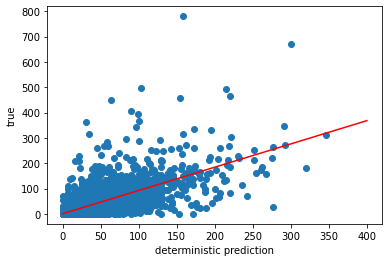

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.554     
Dependent Variable: RH-fix           AIC:                53914.5586
Date:               2022-06-19 16:54 BIC:                53927.8071
No. Observations:   5565             Log-Likelihood:     -26955.   
Df Model:           1                F-statistic:        6902.     
Df Residuals:       5563             Prob (F-statistic): 0.00      
R-squared:          0.554            Scale:              943.80    
---------------------------------------------------------------------
              Coef.    Std.Err.      t      P>|t|     [0.025   0.975]
---------------------------------------------------------------------
const         0.6271     0.4809    1.3039   0.1923   -0.3157   1.5699
det_run       0.9188     0.0111   83.0800   0.0000    0.8971   0.9405
-------------------------------------------------------------------
Omnibus:             6039.454     Durbin-Watson:        1.907      
Prob(Omnibus):       0.000        Jarque-Bera (JB):     1108064.246
Skew:                5.163        Prob(JB):             0.000      
Kurtosis:            71.353       Condition No.:        51         
===================================================================

"""

In [8]:
ols_det = stm.OLS(combined_data["RH-fix"], stm.add_constant(combined_data[["det_run"]])).fit()
plt.scatter(combined_data["det_run"], combined_data[["RH-fix"]])
plt.xlabel("deterministic prediction")
plt.ylabel("true")
x = np.linspace(0, 400)
plt.plot(x, ols_det.predict(stm.add_constant(x)), color="red")
plt.show()

ols_det.summary2()

### OLS on mean

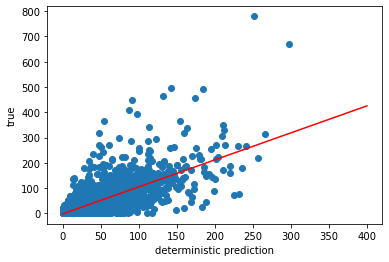

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.603     
Dependent Variable: RH-fix           AIC:                53261.3477
Date:               2022-06-19 16:54 BIC:                53274.5962
No. Observations:   5565             Log-Likelihood:     -26629.   
Df Model:           1                F-statistic:        8455.     
Df Residuals:       5563             Prob (F-statistic): 0.00      
R-squared:          0.603            Scale:              839.27    
---------------------------------------------------------------------
             Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
---------------------------------------------------------------------
const       -2.3939     0.4658   -5.1389   0.0000   -3.3072   -1.4807
mean_pred    1.0690     0.0116   91.9499   0.0000    1.0462    1.0918
-------------------------------------------------------------------
Omnibus:            5419.782      Durbin-Watson:         1.929     
Prob(Omnibus):      0.000         Jarque-Bera (JB):      636516.043
Skew:               4.403         Prob(JB):              0.000     
Kurtosis:           54.648        Condition No.:         48        
===================================================================

"""

In [9]:
ols_mean = stm.OLS(combined_data["RH-fix"], stm.add_constant(combined_data["mean_pred"])).fit()
plt.scatter(combined_data["mean_pred"], combined_data["RH-fix"])
plt.xlabel("deterministic prediction")
plt.ylabel("true")
x = np.linspace(0, 400)
plt.plot(x, ols_mean.predict(stm.add_constant(x)), color="red")
plt.show()

ols_mean.summary2()

### OLS on median

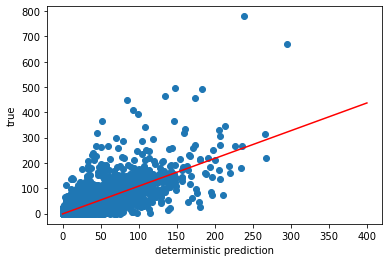

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.606     
Dependent Variable: RH-fix           AIC:                53222.0999
Date:               2022-06-19 16:54 BIC:                53235.3484
No. Observations:   5565             Log-Likelihood:     -26609.   
Df Model:           1                F-statistic:        8554.     
Df Residuals:       5563             Prob (F-statistic): 0.00      
R-squared:          0.606            Scale:              833.37    
--------------------------------------------------------------------
                 Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
--------------------------------------------------------------------
const           -1.4685    0.4584  -3.2033  0.0014  -2.3672  -0.5698
median_pred      1.0966    0.0119  92.4878  0.0000   1.0733   1.1198
-------------------------------------------------------------------
Omnibus:            5499.023      Durbin-Watson:         1.917     
Prob(Omnibus):      0.000         Jarque-Bera (JB):      651551.263
Skew:               4.515         Prob(JB):              0.000     
Kurtosis:           55.234        Condition No.:         46        
===================================================================

"""

In [10]:
ols_median = stm.OLS(combined_data["RH-fix"], stm.add_constant(combined_data["median_pred"])).fit()
plt.scatter(combined_data["median_pred"], combined_data["RH-fix"])
plt.xlabel("deterministic prediction")
plt.ylabel("true")
x = np.linspace(0, 400)
plt.plot(x, ols_median.predict(stm.add_constant(x)), color="red")
plt.show()

ols_median.summary2()

### OLS on mode

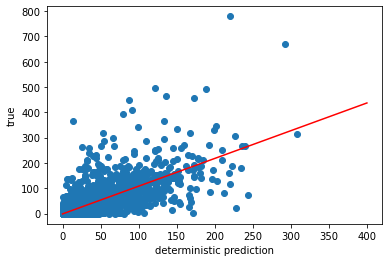

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.582     
Dependent Variable: RH-fix           AIC:                53550.5428
Date:               2022-06-19 16:54 BIC:                53563.7913
No. Observations:   5565             Log-Likelihood:     -26773.   
Df Model:           1                F-statistic:        7745.     
Df Residuals:       5563             Prob (F-statistic): 0.00      
R-squared:          0.582            Scale:              884.04    
---------------------------------------------------------------------
              Coef.    Std.Err.      t      P>|t|     [0.025   0.975]
---------------------------------------------------------------------
const         0.3780     0.4639    0.8148   0.4152   -0.5314   1.2874
mode_pred     1.0761     0.0122   88.0052   0.0000    1.0521   1.1001
-------------------------------------------------------------------
Omnibus:            5585.713      Durbin-Watson:         1.920     
Prob(Omnibus):      0.000         Jarque-Bera (JB):      716000.436
Skew:               4.611         Prob(JB):              0.000     
Kurtosis:           57.798        Condition No.:         44        
===================================================================

"""

In [11]:
ols_mode = stm.OLS(combined_data["RH-fix"], stm.add_constant(combined_data["mode_pred"])).fit()
plt.scatter(combined_data["mode_pred"], combined_data["RH-fix"])
plt.xlabel("deterministic prediction")
plt.ylabel("true")
x = np.linspace(0, 400)
plt.plot(x, ols_median.predict(stm.add_constant(x)), color="red")
plt.show()

ols_mode.summary2()

### OLS on all descriptive statistics

In [12]:
ols_stats = stm.OLS(combined_data["RH-fix"], stm.add_constant(combined_data[["det_run", "mean_pred", "median_pred", "min_pred", "max_pred"]])).fit(cov_type="HC0")
# plt.scatter(combined_data["median_pred"], combined_data["RH-fix"])
# plt.xlabel("deterministic prediction")
# plt.ylabel("true")
# x = np.linspace(0, 400)
# plt.plot(x, ols_median.predict(stm.add_constant(x)), color="red")
# plt.show()

ols_stats.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.607     
Dependent Variable: RH-fix           AIC:                53205.8872
Date:               2022-06-19 16:54 BIC:                53245.6327
No. Observations:   5565             Log-Likelihood:     -26597.   
Df Model:           5                F-statistic:        219.9     
Df Residuals:       5559             Prob (F-statistic): 1.14e-214 
R-squared:          0.608            Scale:              830.35    
--------------------------------------------------------------------
                 Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
--------------------------------------------------------------------
const           -1.4084    0.6579  -2.1409  0.0323  -2.6978  -0.1191
det_run         -0.0076    0.1221  -0.0620  0.9506  -0.2468   0.2317
mean_pred       -0.1296    0.7636  -0.1697  0.8652  -1.6263   1.3671
median_pred      0.9803    0.6702   1.4627  0.1436  -0.3333   2.2940
min_pred         0.3368    0.2111   1.5953  0.1106  -0.0770   0.7505
max_pred         0.0504    0.0566   0.8900  0.3734  -0.0605   0.1613
-------------------------------------------------------------------
Omnibus:            5606.521      Durbin-Watson:         1.918     
Prob(Omnibus):      0.000         Jarque-Bera (JB):      688688.635
Skew:               4.659         Prob(JB):              0.000     
Kurtosis:           56.696        Condition No.:         134       
===================================================================

"""

### Basic model
This is just a basic model, with only significant parameters.

In [13]:
ols_basic = stm.OLS(combined_data["RH-fix"], stm.add_constant(combined_data[["median_pred"]])).fit(cov_type="HC0")
ols_basic.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.606     
Dependent Variable: RH-fix           AIC:                53222.0999
Date:               2022-06-19 16:54 BIC:                53235.3484
No. Observations:   5565             Log-Likelihood:     -26609.   
Df Model:           1                F-statistic:        865.0     
Df Residuals:       5563             Prob (F-statistic): 7.70e-177 
R-squared:          0.606            Scale:              833.37    
--------------------------------------------------------------------
                 Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
--------------------------------------------------------------------
const           -1.4685    0.5544  -2.6489  0.0081  -2.5551  -0.3819
median_pred      1.0966    0.0373  29.4102  0.0000   1.0235   1.1696
-------------------------------------------------------------------
Omnibus:            5499.023      Durbin-Watson:         1.917     
Prob(Omnibus):      0.000         Jarque-Bera (JB):      651551.263
Skew:               4.515         Prob(JB):              0.000     
Kurtosis:           55.234        Condition No.:         46        
===================================================================

"""

### Tests on basic model
#### Chow break test
The different stations might have different results.

In [14]:
median_chow = combined_data[["median_pred"] * 3]
median_chow.columns = [f"median_pred_{i}" for i in ["is-240", "is-260", "is-310"]]

for i, s_n in enumerate(["is-240", "is-260", "is-310"]):
    index = median_chow.index[combined_data[s_n] != 1]
    median_chow.loc[index, median_chow.columns[i]] = 0

m_chow = combined_data.join(median_chow)
stm.OLS(m_chow["RH-fix"], m_chow[["median_pred", "is-240", "is-260", "is-310", "median_pred_is-240", "median_pred_is-260", "median_pred_is-310"]]).fit(cov_type="HC0").f_test("is-240 = is-260 = is-310 = median_pred_is-240 = median_pred_is-260 = median_pred_is-310 = 0")

/Users/micha/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[559.40869551]]), p=0.0, df_denom=5.56e+03, df_num=6>

Thus the statistics parameters differ per station.

In [48]:
ols_break_fixed = stm.OLS(m_chow["RH-fix"], stm.add_constant(m_chow[["median_pred", "is-240", "is-260", "median_pred_is-240", "median_pred_is-260"]])).fit(cov_type="HC0")
ols_break_fixed.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.607     
Dependent Variable: RH-fix           AIC:                53214.8339
Date:               2022-06-19 16:55 BIC:                53254.5794
No. Observations:   5565             Log-Likelihood:     -26601.   
Df Model:           5                F-statistic:        222.6     
Df Residuals:       5559             Prob (F-statistic): 3.52e-217 
R-squared:          0.607            Scale:              831.69    
-------------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------
const                -1.8075   1.0706 -1.6884 0.0913 -3.9058 0.2908
median_pred           1.0580   0.0718 14.7360 0.0000  0.9173 1.1988
is-240                0.3553   1.5333  0.2317 0.8168 -2.6499 3.3604
is-260                0.5920   1.2247  0.4834 0.6288 -1.8084 2.9925
median_pred_is-240    0.0323   0.1007  0.3205 0.7486 -0.1650 0.2296
median_pred_is-260    0.0871   0.0853  1.0211 0.3072 -0.0801 0.2542
-------------------------------------------------------------------
Omnibus:            5571.129      Durbin-Watson:         1.918     
Prob(Omnibus):      0.000         Jarque-Bera (JB):      695427.173
Skew:               4.600         Prob(JB):              0.000     
Kurtosis:           56.986        Condition No.:         170       
===================================================================

"""

#### Ramsey RESET for non-linearity
Thus we accept linearity.

In [16]:
linear_reset(ols_break_fixed, use_f=True, cov_type="HC0")

/Users/micha/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:1081: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  aug = res.fittedvalues[:, None]


<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[1.38229105]]), p=0.2510891107721853, df_denom=5.56e+03, df_num=2>

#### Breusch-Godfrey for hetroskedacity

In [17]:
basic_bp = het_breuschpagan(ols_break_fixed.resid, combined_data[["median_pred"]])
f"P-value: {basic_bp[3]}, thus we {'accept' if basic_bp[3] >= 0.05 else 'reject'} homoskedacity"

'P-value: 2.5867634560370287e-141, thus we reject homoskedacity'

### Non-hetroskedastic basic model
#### Using log
We cannot use log to create a homoskedastic model, since we have many 0 values

In [18]:
ols_basic_log = stm.OLS(np.log(combined_data["RH-fix"] + 1), stm.add_constant(np.log(m_chow[["median_pred", "is-240", "is-260", "median_pred_is-240", "median_pred_is-260"]] + 1))).fit(cov_type="HC0")
ols_basic_log.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.706     
Dependent Variable: RH-fix           AIC:                15380.3761
Date:               2022-06-19 16:54 BIC:                15420.1216
No. Observations:   5565             Log-Likelihood:     -7684.2   
Df Model:           5                F-statistic:        3976.     
Df Residuals:       5559             Prob (F-statistic): 0.00      
R-squared:          0.707            Scale:              0.92757   
-------------------------------------------------------------------
                    Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------
const              -0.2503   0.0205 -12.2152 0.0000 -0.2905 -0.2102
median_pred         0.8900   0.0120  74.0823 0.0000  0.8665  0.9136
is-240             -0.0500   0.0437  -1.1454 0.2520 -0.1356  0.0356
is-260             -0.0827   0.0433  -1.9115 0.0559 -0.1675  0.0021
median_pred_is-240  0.0381   0.0164   2.3196 0.0204  0.0059  0.0702
median_pred_is-260  0.0603   0.0163   3.6989 0.0002  0.0283  0.0922
-------------------------------------------------------------------
Omnibus:              338.275       Durbin-Watson:          1.807  
Prob(Omnibus):        0.000         Jarque-Bera (JB):       444.813
Skew:                 -0.565        Prob(JB):               0.000  
Kurtosis:             3.802         Condition No.:          21     
===================================================================

"""

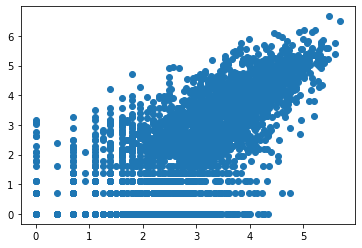

In [19]:
plt.scatter(np.log(combined_data["median_pred"] + 1), np.log(combined_data["RH-fix"] + 1))
plt.show()

In [20]:
basic_ols_log_bp = het_breuschpagan(ols_basic_log.resid, combined_data[["median_pred"]])
f"P-value: {basic_ols_log_bp[3]}, thus we {'accept' if basic_ols_log_bp[3] >= 0.05 else 'reject'} homoskedacity"

'P-value: 6.254575281149824e-134, thus we reject homoskedacity'

#### FWLS

In [21]:
print("White SE")
display(ols_break_fixed.HC0_se)
print("Homoskedicity-only SE")
stm.OLS(m_chow["RH-fix"], m_chow[["median_pred", "is-240", "is-260", "median_pred_is-240", "median_pred_is-260"]]).fit().bse

White SE


median_pred           0.059351
is-240                1.097632
is-260                0.594835
median_pred_is-240    0.092203
median_pred_is-260    0.075091
dtype: float64

Homoskedicity-only SE


median_pred           0.017299
is-240                0.794489
is-260                0.797115
median_pred_is-240    0.026504
median_pred_is-260    0.027323
dtype: float64

In [22]:
e_x_df = combined_data[["median_pred", "min_pred", "max_pred", "RH-fix"]].join(ols_basic.resid.rename("e"))
e_var_given_x1 = e_x_df.groupby(np.log(e_x_df["median_pred"] + 1).round(1)).agg({"e": "var", "median_pred": "count"})
e_var_given_x1 = e_var_given_x1[e_var_given_x1["median_pred"] > 10] # drop values with less then 10 datapoints
e_var_given_x1.rename({"median_pred": "number_of_values"}, axis=1, inplace=True)
e_var_given_x1.reset_index(inplace=True)
e_var_given_x1.loc[:, "median_pred"] = np.exp(e_var_given_x1["median_pred"]) - 1
error_ols = stm.OLS(np.log(e_var_given_x1["e"]), stm.add_constant(e_var_given_x1["median_pred"])).fit() # multiplicative

# plt.scatter(e_var_given_x1["median_pred"], np.log(e_var_given_x1["e"] + 10000))
# plt.show()

display(error_ols.summary2())

# np.exp(error_ols.predict(stm.add_constant(combined_data["median_pred"])))

fwls_basic = stm.WLS(
    m_chow["RH-fix"], 
    stm.add_constant(m_chow[["median_pred", "is-240", "is-260", "median_pred_is-240", "median_pred_is-260"]]), 
    weights= 1/(np.exp(error_ols.predict(stm.add_constant(combined_data["median_pred"]))) -1)
).fit()
fwls_basic.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.592   
Dependent Variable: e                AIC:                174.4835
Date:               2022-06-19 16:55 BIC:                178.1407
No. Observations:   46               Log-Likelihood:     -85.242 
Df Model:           1                F-statistic:        66.17   
Df Residuals:       44               Prob (F-statistic): 2.59e-10
R-squared:          0.601            Scale:              2.4911  
------------------------------------------------------------------
                 Coef.   Std.Err.     t     P>|t|   [0.025  0.975]
------------------------------------------------------------------
const            4.2371    0.3040  13.9369  0.0000  3.6244  4.8498
median_pred      0.0360    0.0044   8.1344  0.0000  0.0271  0.0449
-----------------------------------------------------------------
Omnibus:               9.485        Durbin-Watson:          0.513
Prob(Omnibus):         0.009        Jarque-Bera (JB):       9.014
Skew:                  -1.053       Prob(JB):               0.011
Kurtosis:              3.519        Condition No.:          90   
=================================================================

"""

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Weighted least squares
===================================================================
Model:              WLS              Adj. R-squared:     0.457     
Dependent Variable: RH-fix           AIC:                46402.7272
Date:               2022-06-19 16:55 BIC:                46442.4727
No. Observations:   5565             Log-Likelihood:     -23195.   
Df Model:           5                F-statistic:        937.4     
Df Residuals:       5559             Prob (F-statistic): 0.00      
R-squared:          0.457            Scale:              1.6921    
-------------------------------------------------------------------
                      Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
-------------------------------------------------------------------
const                -0.4272   0.3433 -1.2441 0.2135 -1.1002 0.2459
median_pred           0.9591   0.0259 37.0096 0.0000  0.9083 1.0099
is-240                0.0016   0.4896  0.0033 0.9973 -0.9581 0.9614
is-260               -0.4145   0.4894 -0.8470 0.3971 -1.3739 0.5449
median_pred_is-240    0.0579   0.0367  1.5800 0.1142 -0.0140 0.1298
median_pred_is-260    0.1434   0.0368  3.8942 0.0001  0.0712 0.2155
-------------------------------------------------------------------
Omnibus:            4590.996      Durbin-Watson:         1.914     
Prob(Omnibus):      0.000         Jarque-Bera (JB):      166501.602
Skew:               3.742         Prob(JB):              0.000     
Kurtosis:           28.731        Condition No.:         56        
===================================================================

"""

In [23]:
basic_fwls_bp = het_breuschpagan(fwls_basic.resid, combined_data[["median_pred"]])
f"P-value: {basic_fwls_bp[3]}, thus we {'accept' if basic_fwls_bp[3] >= 0.05 else 'reject'} homoskedacity"

'P-value: 1.150394945659042e-131, thus we reject homoskedacity'

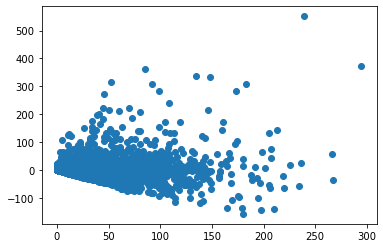

In [24]:
plt.scatter(combined_data["median_pred"], fwls_basic.resid)

#### WLS based on prediction std

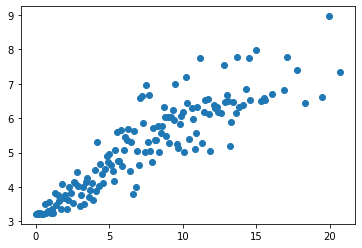

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.788   
Dependent Variable: e                AIC:                270.2708
Date:               2022-06-19 16:55 BIC:                276.2652
No. Observations:   148              Log-Likelihood:     -133.14 
Df Model:           1                F-statistic:        548.2   
Df Residuals:       146              Prob (F-statistic): 2.75e-51
R-squared:          0.790            Scale:              0.35874 
-------------------------------------------------------------------
             Coef.    Std.Err.      t      P>|t|    [0.025   0.975]
-------------------------------------------------------------------
const        3.4143     0.0921   37.0861   0.0000   3.2323   3.5962
pred_std     0.2364     0.0101   23.4133   0.0000   0.2164   0.2563
-----------------------------------------------------------------
Omnibus:              10.686       Durbin-Watson:          1.949 
Prob(Omnibus):        0.005        Jarque-Bera (JB):       11.165
Skew:                 0.567        Prob(JB):               0.004 
Kurtosis:             3.725        Condition No.:          17    
=================================================================

"""

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Weighted least squares
===================================================================
Model:              WLS              Adj. R-squared:     0.281     
Dependent Variable: RH-fix           AIC:                44959.8470
Date:               2022-06-19 16:55 BIC:                44999.5925
No. Observations:   5565             Log-Likelihood:     -22474.   
Df Model:           5                F-statistic:        436.4     
Df Residuals:       5559             Prob (F-statistic): 0.00      
R-squared:          0.282            Scale:              0.010796  
-------------------------------------------------------------------
                      Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
-------------------------------------------------------------------
const                 0.0108   0.0128  0.8438 0.3988 -0.0143 0.0359
median_pred           0.5739   0.0124 46.2529 0.0000  0.5495 0.5982
is-240                0.0031   0.0247  0.1243 0.9011 -0.0453 0.0515
is-260               -0.0004   0.0247 -0.0181 0.9855 -0.0490 0.0481
is-310                0.0082   0.0242  0.3390 0.7346 -0.0392 0.0556
median_pred_is-240    0.2180   0.0228  9.5648 0.0000  0.1733 0.2627
median_pred_is-260    0.2521   0.0240 10.4879 0.0000  0.2050 0.2993
median_pred_is-310    0.1037   0.0244  4.2487 0.0000  0.0559 0.1516
-------------------------------------------------------------------
Omnibus:           6963.661   Durbin-Watson:      1.930            
Prob(Omnibus):     0.000      Jarque-Bera (JB):   1504076.158      
Skew:              6.689      Prob(JB):           0.000            
Kurtosis:          82.420     Condition No.:      14946324440832462
===================================================================
* The condition number is large (1e+16). This might indicate
strong multicollinearity or other numerical problems.
"""

In [25]:
e_std_df = combined_data[["median_pred", "min_pred", "max_pred", "RH-fix", "pred_std"]].join(ols_basic.resid.rename("e"))
e_var_given_std = e_std_df.groupby(e_std_df["pred_std"].round(1)).agg({"e": "var", "pred_std": "mean", "median_pred": "count"})
e_var_given_std = e_var_given_std[e_var_given_std["median_pred"] > 10]

plt.scatter(e_var_given_std["pred_std"], np.log(e_var_given_std["e"] + 25)) # If we add + 25, we get a staight line
plt.show()

error_std_ols = stm.OLS(np.log(e_var_given_std["e"] + 25), stm.add_constant(e_var_given_std["pred_std"])).fit()
display(error_std_ols.summary2())

std_wls_basic = stm.WLS(m_chow["RH-fix"], stm.add_constant(m_chow[["median_pred", "is-240", "is-260", "is-310", "median_pred_is-240", "median_pred_is-260", "median_pred_is-310"]]), weights= 1/((np.exp(error_std_ols.predict(stm.add_constant(combined_data["pred_std"]))) - 25)**2)).fit()
display(std_wls_basic.summary2())

In [26]:
basic_std_wls_bp = het_breuschpagan(std_wls_basic.resid, combined_data[["median_pred"]])
f"P-value: {basic_std_wls_bp[3]}, thus we {'accept' if basic_std_wls_bp[3] >= 0.05 else 'reject'} homoskedacity"

'P-value: 1.6213869700545717e-131, thus we reject homoskedacity'

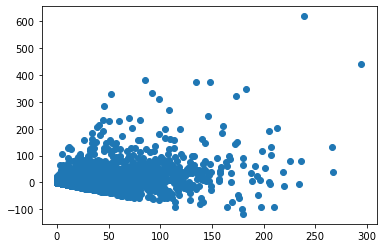

In [27]:
plt.scatter(combined_data["median_pred"], std_wls_basic.resid)

Ik weet oprecht niet waarom, maar ik kan deze hetroskedasity niet wegkrijgen. Dit zou wel mogelijk moeten zijn.

## Basic model with current statistics
### Add additional data

In [28]:
import datetime

current_statistics_hourly = true_weather[["DD", "FH", "T", "P", "N", "U"]] # ik wil ook nog Q toevoegen, alleen die is 's nachts altijd 0, dus dan kan het gemiddelde ofzo
current_statistics = current_statistics_hourly.groupby([pd.Grouper(freq="D", level=0), current_statistics_hourly.index.get_level_values(1)]).last()
current_statistics.index = pd.MultiIndex.from_arrays([current_statistics.index.get_level_values(0) - datetime.timedelta(1), current_statistics.index.get_level_values(1)])
current_statistics: pd.DataFrame
current_statistics[current_statistics.index.get_level_values(0) >= datetime.datetime(2010, 1, 1)]
current_statistics.index.rename({"STN": "loc_nr"}, inplace=True)

current_statistics.loc[:, "D-N"] = ((current_statistics["DD"] > 337.5) | (current_statistics["DD"] <= 22.5)).astype(int)
current_statistics.loc[:, "D-NE"] = ((current_statistics["DD"] > 22.5) & (current_statistics["DD"] <= 67.5)).astype(int)
current_statistics.loc[:, "D-E"] = ((current_statistics["DD"] > 67.5) & (current_statistics["DD"] <= 112.5)).astype(int)
current_statistics.loc[:, "D-SE"] = ((current_statistics["DD"] > 112.5) & (current_statistics["DD"] <= 157.5)).astype(int)
current_statistics.loc[:, "D-S"] = ((current_statistics["DD"] > 157.5) & (current_statistics["DD"] <= 202.5)).astype(int)
current_statistics.loc[:, "D-SW"] = ((current_statistics["DD"] > 202.5) & (current_statistics["DD"] <= 247.5)).astype(int)
current_statistics.loc[:, "D-W"] = ((current_statistics["DD"] > 247.5) & (current_statistics["DD"] <= 292.5)).astype(int)
current_statistics.loc[:, "D-NW"] = ((current_statistics["DD"] > 292.5) & (current_statistics["DD"] <= 337.5)).astype(int)

combined_additional_data = m_chow.join(current_statistics)
combined_additional_data.dropna(inplace=True) # FIXME het lieft los ik gewoon dit probleem op
combined_additional_data

,,det_run,E1,E2,E3,E4,E5,E6,E7,E8,E9,...,N,U,D-N,D-NE,D-E,D-SE,D-S,D-SW,D-W,D-NW
date,loc_nr,,,,,,,,,,,,,,,,,,,,,
2016-04-01,260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,70.0,0,0,0,1,0,0,0,0
2016-04-02,260,1.0,1.0,5.0,2.0,3.0,3.0,1.0,1.0,2.0,1.0,...,8.0,96.0,0,0,0,0,1,0,0,0
2016-04-03,260,34.0,20.0,8.0,22.0,19.0,26.0,19.0,28.0,12.0,25.0,...,8.0,94.0,0,0,1,0,0,0,0,0
2016-04-04,260,17.0,44.0,54.0,29.0,29.0,44.0,54.0,9.0,61.0,22.0,...,7.0,85.0,0,0,0,0,0,1,0,0
2016-04-05,260,30.0,18.0,8.0,24.0,58.0,36.0,41.0,30.0,43.0,25.0,...,0.0,75.0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,56.0,0,1,0,0,0,0,0,0
2021-04-27,240,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,...,8.0,74.0,1,0,0,0,0,0,0,0
2021-04-28,240,41.0,27.0,10.0,38.0,29.0,5.0,31.0,14.0,32.0,20.0,...,8.0,90.0,0,0,0,0,0,0,0,1


### Basic model with additional statistics

In [29]:
median_direction = combined_additional_data[["median_pred"] * 8]
median_direction.columns = [f"median_pred_{i}" for i in ["D-N", "D-NE", "D-E", "D-SE", "D-S", "D-SW", "D-W", "D-NW"]]
for i, c_n in enumerate(["D-N", "D-NE", "D-E", "D-SE", "D-S", "D-SW", "D-W", "D-NW"]):
    index = median_direction.index[combined_additional_data[c_n] != 1]
    median_direction.loc[index, median_direction.columns[i]] = 0

combined_with_binary = combined_additional_data.join(median_direction)
combined_with_binary.to_hdf("combined_with_binary.hdf5", "binary")
combined_with_binary


/Users/micha/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,,det_run,E1,E2,E3,E4,E5,E6,E7,E8,E9,...,D-W,D-NW,median_pred_D-N,median_pred_D-NE,median_pred_D-E,median_pred_D-SE,median_pred_D-S,median_pred_D-SW,median_pred_D-W,median_pred_D-NW
date,loc_nr,,,,,,,,,,,,,,,,,,,,,
2016-04-01,260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-04-02,260,1.0,1.0,5.0,2.0,3.0,3.0,1.0,1.0,2.0,1.0,...,0,0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
2016-04-03,260,34.0,20.0,8.0,22.0,19.0,26.0,19.0,28.0,12.0,25.0,...,0,0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0
2016-04-04,260,17.0,44.0,54.0,29.0,29.0,44.0,54.0,9.0,61.0,22.0,...,0,0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0
2016-04-05,260,30.0,18.0,8.0,24.0,58.0,36.0,41.0,30.0,43.0,25.0,...,0,0,0.0,0.0,0.0,0.0,0.0,31.5,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-04-27,240,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-04-28,240,41.0,27.0,10.0,38.0,29.0,5.0,31.0,14.0,32.0,20.0,...,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0


In [30]:
max_model = stm.OLS(combined_with_binary["RH-fix"], stm.add_constant(combined_with_binary[["median_pred", "is-240", "is-260", "median_pred_is-240", "median_pred_is-260", "min_pred", "max_pred", "mean_pred", "mode_pred", "T", "P", "N", "U", "FH", "D-N", "D-NE", "D-E", "D-SE", "D-S", "D-SW", "D-W", "median_pred_D-N", "median_pred_D-NE", "median_pred_D-E", "median_pred_D-SE", "median_pred_D-S", "median_pred_D-SW", "median_pred_D-W"]])).fit(cov_type="HC0")
max_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Results: Ordinary least squares
=======================================================================
Model:                OLS               Adj. R-squared:      0.615     
Dependent Variable:   RH-fix            AIC:                 53110.4912
Date:                 2022-06-19 16:55  BIC:                 53302.5893
No. Observations:     5564              Log-Likelihood:      -26526.   
Df Model:             28                F-statistic:         95.95     
Df Residuals:         5535              Prob (F-statistic):  0.00      
R-squared:            0.617             Scale:               814.28    
-----------------------------------------------------------------------
                     Coef.   Std.Err.    z    P>|z|    [0.025   0.975] 
-----------------------------------------------------------------------
const              -138.9616  43.6599 -3.1828 0.0015 -224.5334 -53.3899
median_pred           1.2054   0.6797  1.7735 0.0761   -0.1267   2.5375
is-240                0.2835   1.4354  0.1975 0.8434   -2.5298   3.0968
is-260               -0.4071   1.0871 -0.3745 0.7081   -2.5378   1.7236
median_pred_is-240   -0.0069   0.0971 -0.0714 0.9431   -0.1973   0.1835
median_pred_is-260    0.0688   0.0824  0.8356 0.4034   -0.0926   0.2302
min_pred              0.3147   0.1989  1.5819 0.1137   -0.0752   0.7045
max_pred              0.0514   0.0535  0.9601 0.3370   -0.0535   0.1563
mean_pred            -0.1492   0.7079 -0.2107 0.8331   -1.5367   1.2384
mode_pred            -0.1199   0.1617 -0.7417 0.4583   -0.4369   0.1970
T                     0.0084   0.0068  1.2336 0.2174   -0.0049   0.0217
P                     0.0135   0.0042  3.2351 0.0012    0.0053   0.0217
N                    -0.1355   0.1271 -1.0660 0.2864   -0.3846   0.1136
U                    -0.0063   0.0339 -0.1848 0.8534   -0.0726   0.0601
FH                   -0.0490   0.0199 -2.4687 0.0136   -0.0879  -0.0101
D-N                   1.8663   1.3775  1.3548 0.1755   -0.8336   4.5662
D-NE                  1.8395   1.6867  1.0906 0.2755   -1.4664   5.1454
D-E                   3.3522   1.4764  2.2704 0.0232    0.4584   6.2460
D-SE                  1.1795   1.9284  0.6116 0.5408   -2.6001   4.9590
D-S                   1.0295   2.2258  0.4625 0.6437   -3.3329   5.3919
D-SW                  5.8343   1.5738  3.7072 0.0002    2.7498   8.9189
D-W                   1.7150   1.7513  0.9793 0.3274   -1.7175   5.1475
median_pred_D-N      -0.2582   0.0906 -2.8501 0.0044   -0.4357  -0.0806
median_pred_D-NE     -0.1328   0.1979 -0.6709 0.5023   -0.5206   0.2551
median_pred_D-E      -0.2334   0.1378 -1.6939 0.0903   -0.5034   0.0367
median_pred_D-SE      0.0584   0.1511  0.3864 0.6992   -0.2378   0.3546
median_pred_D-S       0.0014   0.1293  0.0111 0.9911   -0.2519   0.2548
median_pred_D-SW     -0.2032   0.0914 -2.2238 0.0262   -0.3822  -0.0241
median_pred_D-W      -0.0505   0.1058 -0.4777 0.6329   -0.2579   0.1568
-----------------------------------------------------------------------
Omnibus:              5479.819       Durbin-Watson:          1.931     
Prob(Omnibus):        0.000          Jarque-Bera (JB):       612865.600
Skew:                 4.511          Prob(JB):               0.000     
Kurtosis:             53.618         Condition No.:          1211453   
=======================================================================
* The condition number is large (1e+06). This might indicate
strong multicollinearity or other numerical problems.
"""

#### Only use significant

In [49]:
additional_model = stm.OLS(combined_with_binary["RH-fix"], stm.add_constant((combined_with_binary[["median_pred", "P", "FH", "D-N"]]))).fit(cov_type="HC0")
display(additional_model.pvalues.idxmax(), additional_model.pvalues.max())
display(additional_model.summary2())

'const'

0.003131129407222549

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.608     
Dependent Variable: RH-fix           AIC:                53184.2795
Date:               2022-06-19 16:55 BIC:                53217.3998
No. Observations:   5564             Log-Likelihood:     -26587.   
Df Model:           4                F-statistic:        275.8     
Df Residuals:       5559             Prob (F-statistic): 1.31e-216 
R-squared:          0.608            Scale:              828.71    
-------------------------------------------------------------------
                 Coef.   Std.Err.    z    P>|z|    [0.025   0.975] 
-------------------------------------------------------------------
const          -118.0397  39.9517 -2.9546 0.0031 -196.3436 -39.7359
median_pred       1.1104   0.0389 28.5361 0.0000    1.0341   1.1867
P                 0.0117   0.0039  3.0064 0.0026    0.0041   0.0194
FH               -0.0570   0.0159 -3.5749 0.0004   -0.0882  -0.0257
D-N              -3.5428   1.0583 -3.3477 0.0008   -5.6170  -1.4686
-------------------------------------------------------------------
Omnibus:            5450.904      Durbin-Watson:         1.924     
Prob(Omnibus):      0.000         Jarque-Bera (JB):      632038.928
Skew:               4.455         Prob(JB):              0.000     
Kurtosis:           54.448        Condition No.:         1110376   
===================================================================
* The condition number is large (1e+06). This might indicate
strong multicollinearity or other numerical problems.
"""

In [32]:
combined_with_binary[["median_pred", "is-240", "is-260", "is-310", "median_pred_is-240", "median_pred_is-260", "median_pred_is-310", "P", "FH", "D-N", "D-NE", "D-E", "D-SE", "D-S", "D-SW", "D-W", "D-NW"]].corr().replace(1, np.nan).idxmax().to_frame().join(combined_with_binary[["median_pred", "is-240", "is-260", "is-310", "median_pred_is-240", "median_pred_is-260", "median_pred_is-310", "P", "FH", "D-N", "D-NE", "D-E", "D-SE", "D-S", "D-SW", "D-W", "D-NW"]].corr().replace(1, np.nan).max().rename("max"))

,0,max
median_pred,median_pred_is-240,0.528805
is-240,median_pred_is-240,0.461864
is-260,median_pred_is-260,0.465986
is-310,median_pred_is-310,0.453840
median_pred_is-240,median_pred,0.528805
median_pred_is-260,median_pred,0.492631
median_pred_is-310,median_pred,0.515546
P,D-NE,0.132896
FH,is-310,0.389533
D-N,P,0.104820


#### Ramsey RESET

In [33]:
linear_reset(max_model, use_f=True, cov_type="HC0")

/Users/micha/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:1081: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  aug = res.fittedvalues[:, None]


<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[4.37694205]]), p=0.01260724959926315, df_denom=5.53e+03, df_num=2>

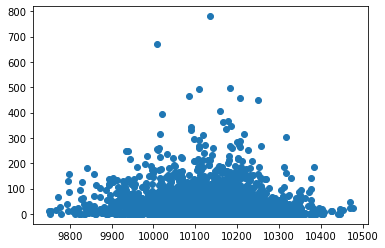

In [34]:
plt.scatter(combined_with_binary[combined_with_binary["R"] == 1]["P"], combined_with_binary[combined_with_binary["R"] == 1]["RH-fix"])

## Predictive rain prediction model
First predict rain probability, then predict how much it would likely rain.

In [35]:
from statsmodels.miscmodels.ordinal_model import OrderedModel

In [36]:
num_pos =  (combined_with_binary[[f"E{i+1}" for i in range(50)]] > 0).sum(axis=1).rename("num_pos")
num_high_pos = (combined_with_binary[[f"E{i+1}" for i in range(50)]] > 20).sum(axis=1).rename("num_high_pos")
num_very_pos = (combined_with_binary[[f"E{i+1}" for i in range(50)]] > 100).sum(axis=1).rename("num_very_pos")
combined_with_perc = combined_with_binary.join(num_pos).join(num_high_pos).join(num_very_pos)
combined_with_perc

,,det_run,E1,E2,E3,E4,E5,E6,E7,E8,E9,...,median_pred_D-NE,median_pred_D-E,median_pred_D-SE,median_pred_D-S,median_pred_D-SW,median_pred_D-W,median_pred_D-NW,num_pos,num_high_pos,num_very_pos
date,loc_nr,,,,,,,,,,,,,,,,,,,,,
2016-04-01,260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,0,0
2016-04-02,260,1.0,1.0,5.0,2.0,3.0,3.0,1.0,1.0,2.0,1.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,42,0,0
2016-04-03,260,34.0,20.0,8.0,22.0,19.0,26.0,19.0,28.0,12.0,25.0,...,0.0,22.0,0.0,0.0,0.0,0.0,0.0,50,29,0
2016-04-04,260,17.0,44.0,54.0,29.0,29.0,44.0,54.0,9.0,61.0,22.0,...,0.0,0.0,0.0,0.0,29.0,0.0,0.0,50,39,0
2016-04-05,260,30.0,18.0,8.0,24.0,58.0,36.0,41.0,30.0,43.0,25.0,...,0.0,0.0,0.0,0.0,31.5,0.0,0.0,50,34,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
2021-04-27,240,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13,0,0
2021-04-28,240,41.0,27.0,10.0,38.0,29.0,5.0,31.0,14.0,32.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,21.0,50,25,0


In [37]:
combined_with_perc.columns

Index(['det_run', 'E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10',
       'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E20',
       'E21', 'E22', 'E23', 'E24', 'E25', 'E26', 'E27', 'E28', 'E29', 'E30',
       'E31', 'E32', 'E33', 'E34', 'E35', 'E36', 'E37', 'E38', 'E39', 'E40',
       'E41', 'E42', 'E43', 'E44', 'E45', 'E46', 'E47', 'E48', 'E49', 'E50',
       'E51', 'mean_pred', 'median_pred', 'min_pred', 'max_pred', 'pred_std',
       'pred_skew', 'pred_kurt', 'mode_pred', 'mode2_pred', 'mean_det_pred',
       'RH-fix', 'R', 'is-260', 'is-310', 'is-240', 'median_pred_is-240',
       'median_pred_is-260', 'median_pred_is-310', 'DD', 'FH', 'T', 'P', 'N',
       'U', 'D-N', 'D-NE', 'D-E', 'D-SE', 'D-S', 'D-SW', 'D-W', 'D-NW',
       'median_pred_D-N', 'median_pred_D-NE', 'median_pred_D-E',
       'median_pred_D-SE', 'median_pred_D-S', 'median_pred_D-SW',
       'median_pred_D-W', 'median_pred_D-NW', 'num_pos', 'num_high_pos',
       'num_very_pos'],
      

In [38]:
def perc_corr_pred(model, data, true, perc = 0.5):
    pred_value = np.zeros(len(data))
    is_corr = np.zeros(len(data))
    true_value = np.array(true)
    
    pred_value = model.predict(data)[1] > perc

    return np.equal(pred_value, true_value).mean()

In [39]:
logit_model = OrderedModel(combined_with_binary["R"], combined_with_perc[["num_pos"]], distr="logit").fit(method="bfgs")
display(perc_corr_pred(logit_model, combined_with_perc[["num_pos"]], combined_with_binary["R"]))
display(logit_model.summary())
display(logit_model.prsquared)

Optimization terminated successfully.
         Current function value: 0.355100
         Iterations: 14
         Function evaluations: 17
         Gradient evaluations: 17


0.8594536304816679

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                      R   Log-Likelihood:                -1975.8
Model:                   OrderedModel   AIC:                             3956.
Method:            Maximum Likelihood   BIC:                             3969.
Date:                Sun, 19 Jun 2022                                         
Time:                        16:55:09                                         
No. Observations:                5564                                         
Df Residuals:                    5562                                         
Df Model:                           2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
num_pos        0.1155      0.003     37.113      0.000       0.109       0.122
0.0/1.0        3.8857      0.138     28.189      0.000       3.615       4.156
==============================================================================
"""

0.47267781327798664

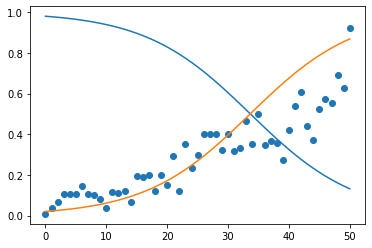

In [40]:
_data = combined_with_perc.groupby("num_pos").mean()["R"]
plt.scatter(_data.index, _data.values)
x = np.arange(0, 51)
plt.plot(x, logit_model.predict(x))
plt.show()

In [41]:
gompit_model = OrderedModel(combined_with_binary["R"], combined_with_perc[["num_pos"]], distr=sts.gumbel_r).fit(method="bfgs")
display(perc_corr_pred(gompit_model, combined_with_perc[["num_pos"]], combined_with_binary["R"]))
display(gompit_model.summary())
display(gompit_model.prsquared)

Optimization terminated successfully.
         Current function value: 0.347179
         Iterations: 13
         Function evaluations: 16
         Gradient evaluations: 16


0.8632278936017254

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                      R   Log-Likelihood:                -1931.7
Model:                   OrderedModel   AIC:                             3867.
Method:            Maximum Likelihood   BIC:                             3881.
Date:                Sun, 19 Jun 2022                                         
Time:                        16:55:10                                         
No. Observations:                5564                                         
Df Residuals:                    5562                                         
Df Model:                           2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
num_pos        0.0881      0.003     34.611      0.000       0.083       0.093
0.0/1.0        3.6260      0.121     29.923      0.000       3.389       3.864
==============================================================================
"""

0.4844410988106389

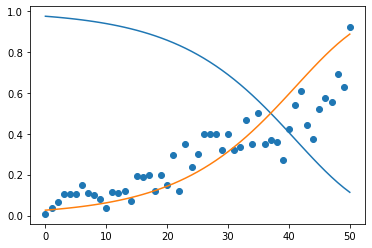

In [42]:
_data = combined_with_perc.groupby("num_pos").mean()["R"]
plt.scatter(_data.index, _data.values)
x = np.arange(0, 51)
plt.plot(x, gompit_model.predict(x))
plt.show()

In [43]:
expon_model = OrderedModel(combined_with_binary["R"], combined_with_perc[["num_pos"]], distr=sts.expon).fit(method="bfgs")
display(perc_corr_pred(expon_model, combined_with_perc[["num_pos"]], combined_with_binary["R"]))
display(expon_model.summary())
display(expon_model.prsquared)

Optimization terminated successfully.
         Current function value: 0.337952
         Iterations: 14
         Function evaluations: 17
         Gradient evaluations: 17


0.8684399712437095

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                      R   Log-Likelihood:                -1880.4
Model:                   OrderedModel   AIC:                             3765.
Method:            Maximum Likelihood   BIC:                             3778.
Date:                Sun, 19 Jun 2022                                         
Time:                        16:55:11                                         
No. Observations:                5564                                         
Df Residuals:                    5562                                         
Df Model:                           2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
num_pos        0.0645      0.002     30.829      0.000       0.060       0.069
0.0/1.0        3.3215      0.104     32.004      0.000       3.118       3.525
==============================================================================
"""

0.4981438763007129

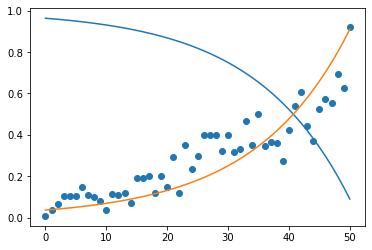

In [44]:
_data = combined_with_perc.groupby("num_pos").mean()["R"]
plt.scatter(_data.index, _data.values)
x = np.arange(0, 51)
plt.plot(x, expon_model.predict(x))
plt.show()

In [45]:
wald_model = OrderedModel(combined_with_binary["R"], combined_with_perc[["num_pos"]], distr=sts.wald).fit(method="bfgs")
display(perc_corr_pred(wald_model, combined_with_perc[["num_pos"]], combined_with_binary["R"]))
display(wald_model.summary())
display(wald_model.prsquared)

Optimization terminated successfully.
         Current function value: 0.338369
         Iterations: 15
         Function evaluations: 21
         Gradient evaluations: 21


0.8662832494608196

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                      R   Log-Likelihood:                -1882.7
Model:                   OrderedModel   AIC:                             3769.
Method:            Maximum Likelihood   BIC:                             3783.
Date:                Sun, 19 Jun 2022                                         
Time:                        16:55:11                                         
No. Observations:                5564                                         
Df Residuals:                    5562                                         
Df Model:                           2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
num_pos        0.0567      0.002     26.233      0.000       0.052       0.061
0.0/1.0        3.0634      0.107     28.587      0.000       2.853       3.273
==============================================================================
"""

0.4975240120996641

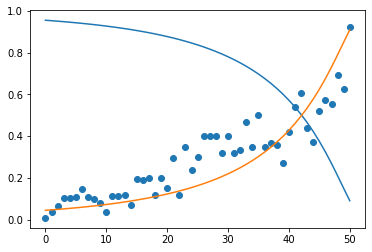

In [46]:
_data = combined_with_perc.groupby("num_pos").mean()["R"]
plt.scatter(_data.index, _data.values)
x = np.arange(0, 51)
plt.plot(x, wald_model.predict(x))
plt.show()

In [47]:
wald_model = OrderedModel(combined_with_binary["R"], combined_with_perc[["num_pos", "num_high_pos"]], distr=sts.wald).fit(method="bfgs")
# display(perc_corr_pred(wald_model, combined_with_perc[["num_pos"]], combined_with_binary["R"]))
display(wald_model.summary())
display(wald_model.prsquared)

Optimization terminated successfully.
         Current function value: 0.303206
         Iterations: 13
         Function evaluations: 20
         Gradient evaluations: 20


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                      R   Log-Likelihood:                -1687.0
Model:                   OrderedModel   AIC:                             3380.
Method:            Maximum Likelihood   BIC:                             3400.
Date:                Sun, 19 Jun 2022                                         
Time:                        16:55:13                                         
No. Observations:                5564                                         
Df Residuals:                    5561                                         
Df Model:                           3                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
num_pos          0.0492      0.002     23.927      0.000       0.045       0.053
num_high_pos     0.0053      0.000     18.493      0.000       0.005       0.006
0.0/1.0          2.8095      0.101     27.940      0.000       2.612       3.007
================================================================================
"""

0.5497415042904881